## Zadanie - klasyczna detekcja obiektów

Celem tego zadania jest własnoręczne zbudowanie, debugowanie i przetestowanie przez Ciebie prostego pipeline'u do rozpoznawania obiektów opartego o klasyczne metody przetwarzania obrazów.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List
from utils import *

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Twoim zadaniem będzie zaproponowanie algorytmu detekcji, który przyjmie obraz wejściowy i wykryje na nim obiekty - poszczególne tabletki, zwracając informację o ich położeniach i gatunkach.
Reprezentacja tej informacji jest dowolna: pary koordynat (X,Y) środka obiektu, bounding boksy (XYHW), czy kontury - istotne jest jedynie, by liczba detekcji możliwie dobrze zgadzała się ze stanem faktycznym.

Zadanie ma charakter projektowy i nie jest podzielone na szczegółowo opisane podpunkty, ponieważ można do niego podejść na różne sposoby (czytaj dalej).

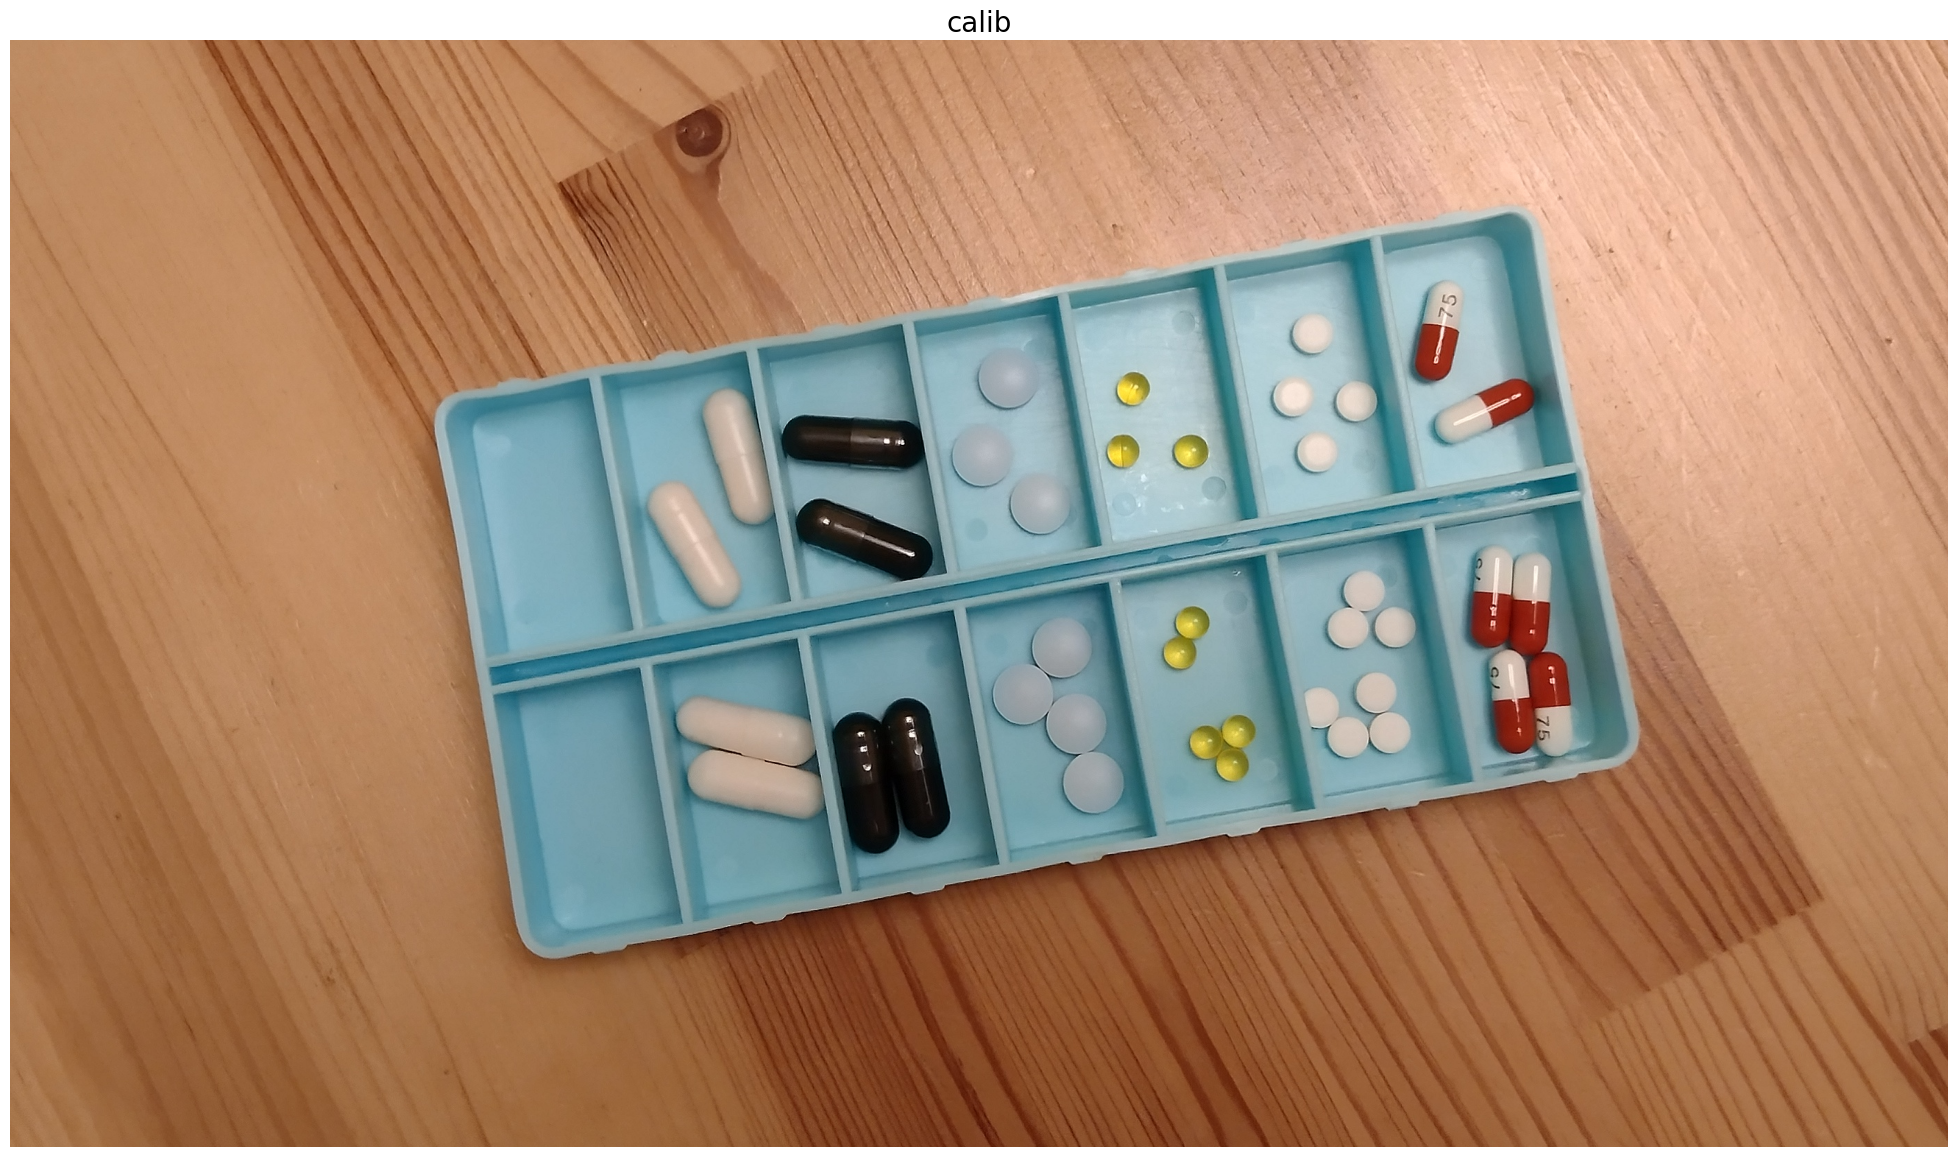

In [2]:
calib = cv2.imread('images/calib.png', cv2.IMREAD_COLOR)
display_images([calib], ['calib'])

Występuje 6 klas obiektów; patrząc na organizer od lewej:

In [3]:
class PillType(Enum):
    PROBIO = 1  # duże białe kapsułki
    CARBON = 2  # duże czarne kapsułki
    KETO = 3  # niebieskie tabletki
    ESPU = 4  # małe żółte kapsułki
    BIOX = 5  # małe białe tabletki
    LINE = 6  # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

Górny rząd zawiera łatwiejsze przykłady pojedynczych instancji, podczas gdy w rzędzie dolnym obiekty stykają się ze sobą, co utrudnia identyfikację.
Jak widzisz, nie wszystkie klasy są tak samo "wdzięczne" do wykrycia.
Nie próbuj zatem robić wszystkiego naraz - rekomendowane jest podejście sekwencyjne: najpierw zaimplementuj algorytm detekcji dla jednej klasy, przetestuj go i napraw, rozszerz o możliwość detekcji stykających się obiektów (_jak to zrobić?_), a dopiero potem podejmij kolejną klasę.

Wykorzystaj narzędzia poznane do tej pory (konwersje przestrzeni barw, binaryzację, detekcję krawędzi, etc.) by sprowadzić obraz do takiej postaci, w której detekcję interesujących obiektów będzie można wykonać za pomocą zwyczajnej ekstrakcji komponentów spójności - [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0).
Wspomóż się operacjami morfologicznymi jeśli to potrzebne, i nie wahaj się stosować jakichkolwiek narzędzi jakie znajdziesz -
wszystkie chwyty są dozwolone, za wyjątkiem stosowania metod MLowych.

W zależności od wybranej reprezentacji wykrytych obiektów, zaimplementuj metodę wizualizacji wyników.

Nie usuwaj notebooka, w którym będziesz debugować algorytm!
Przyda się podczas rozmowy, jeśli zajdzie konieczność wyjaśnienia dlaczego twój algorytm popełnia błędy - możliwość pokazania krok po kroku wykonywanych operacji będzie istotna.

### Rozwiązanie:

In [4]:
def detect_keto(img_bgr):
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_RGB2HSV)
    H, S, V = cv2.split(img_hsv)
    ret, thresh = cv2.threshold(S, 28, 255, cv2.THRESH_BINARY_INV)
    # morpho open
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((4, 4), np.uint8), iterations=2)
    # distans transform
    dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L1, 3)
    thresh2 = cv2.normalize(dist_transform, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    # erode
    thresh2 = cv2.erode(thresh2, np.ones((3, 3), np.uint8), iterations=7)
    contours, hierarchy = cv2.findContours(thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    keto = [c for c in contours if cv2.contourArea(c) > 1000]
    keto = [Pill(PillType.KETO, cv2.boundingRect(c)) for c in keto]
    return keto


In [5]:
def detect_carbon(
        img: np.ndarray,
        kernel_size: int = 3,
        iterations: int = 3,
        thresh_val: int = 40):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(img)
    ret, thresh = cv2.threshold(L, thresh_val, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=iterations)

    # distance transform
    dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L1, 5)
    dist_transform = cv2.normalize(dist_transform, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    thresh = dist_transform
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    pills = [c for c in contours if cv2.contourArea(c) > 4000]
    pills = [Pill(PillType.CARBON, cv2.boundingRect(c)) for c in pills]
    return pills

In [6]:
def detect_espu(img, morph=True, kernel_size=3, iterations=1, thresh_val=180):
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)
    ret, thresh = cv2.threshold(b, thresh_val, 255, cv2.THRESH_BINARY)

    if morph:
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=iterations)
    post = cv2.erode(thresh, kernel, iterations=1)
    contours, hierarchy = cv2.findContours(post, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    pills = [c for c in contours if cv2.contourArea(c) > 90]
    pills = [Pill(PillType.ESPU, cv2.boundingRect(c)) for c in pills]
    return pills

In [7]:
def detect_biox_probio(img):
    w = detect_whites(img)
    contours, hierarchy = cv2.findContours(w, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # feat elipses
    ellipses = []
    rectangels = []
    for c in contours:
        if len(c) > 5:
            ellipse = cv2.fitEllipse(c)
            ellipses.append(ellipse)
            rectangels.append(cv2.boundingRect(c))
            
    
    # draw ellipses
    result = img.copy()
    bluexy = blue_xy(img)
    pills_probio = []
    pills_biox = []

    for i, e in enumerate(ellipses):
        text = str(calculate_aspect_ratio(e))
        area = cv2.contourArea(c)
        x, y = e[0]
        r = rectangels[i]
        if any([abs(np.linalg.norm(np.array([x, y]) - np.array([bx, by]))) < 90 for bx, by in bluexy]):
            continue
        if calculate_aspect_ratio(e) > 0.4:
            pills_biox.append(Pill(PillType.BIOX, r))

        if calculate_aspect_ratio(e) < 0.3:
            pills_probio.append(Pill(PillType.PROBIO, r))
    return pills_biox, pills_probio


In [8]:
class Pill:
    """Output of object detection, represents a single instance"""

    def __init__(self, pill_type: PillType, location: Any):
        self.type = pill_type
        self.location = location

    def __repr__(self):
        return f'{self.type.name} @ {self.location}'

In [9]:
def detect_objects(image: np.ndarray, **kwargs) -> List[Pill]:
    # TU BĘDZIE TWOJA IMPLEMENTACJA DETEKTORA
    pills = []

    # KETO
    keto = detect_keto(image)
    pills.extend(keto)

    # CARBON
    carbon = detect_carbon(image)
    pills.extend(carbon)

    # ESPU
    espu = detect_espu(image)
    pills.extend(espu)

    # PROBI, BIOX
    biox, probio = detect_biox_probio(image)
    pills.extend(biox)
    pills.extend(probio)

    return pills


In [10]:
COLORMAP = {
    # RGB colorspace
    PillType.PROBIO: (255, 255, 255),
    PillType.CARBON: (0, 0, 0),
    PillType.KETO: (0, 0, 255),
    PillType.ESPU: (255, 255, 0),
    PillType.BIOX: (255, 0, 255),
    PillType.LINE: (255, 0, 0),
}


def display_objects(image: np.ndarray, objects: List[Pill]) -> None:
    image = image.copy()
    for obj in objects:
        color = COLORMAP[obj.type]
        x, y, w, h = obj.location
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = obj.type.name
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        color = (0, 255, 0)
        thickness = 2
        text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
        cv2.putText(image, text, (x + w // 2 - text_size[0] // 2, y + h // 2 + text_size[1] // 2), font, font_scale,
                    color, thickness)
    plt.imshow(image)

In [11]:
detect_objects(calib)

[KETO @ (1535, 1039, 52, 58),
 KETO @ (1509, 960, 58, 67),
 KETO @ (1449, 920, 51, 59),
 KETO @ (1492, 857, 57, 58),
 KETO @ (1461, 639, 54, 56),
 KETO @ (1391, 575, 48, 54),
 KETO @ (1421, 477, 42, 44),
 CARBON @ (1188, 954, 170, 222),
 CARBON @ (1136, 665, 197, 116),
 CARBON @ (1115, 545, 206, 74),
 ESPU @ (1746, 1034, 32, 34),
 ESPU @ (1709, 1002, 38, 34),
 ESPU @ (1751, 987, 34, 35),
 ESPU @ (1671, 874, 31, 31),
 ESPU @ (1688, 831, 30, 34),
 ESPU @ (1686, 582, 32, 33),
 ESPU @ (1589, 581, 34, 33),
 ESPU @ (1603, 492, 35, 34),
 BIOX @ (569, 1456, 29, 45),
 BIOX @ (449, 1397, 8, 12),
 BIOX @ (786, 1387, 8, 5),
 BIOX @ (2127, 1368, 6, 4),
 BIOX @ (17, 1562, 34, 37),
 BIOX @ (6, 1440, 29, 29),
 BIOX @ (2552, 1322, 4, 7),
 BIOX @ (414, 1248, 10, 11),
 BIOX @ (1921, 991, 27, 29),
 BIOX @ (1980, 989, 26, 24),
 BIOX @ (1885, 953, 22, 25),
 BIOX @ (1961, 930, 25, 28),
 BIOX @ (1988, 838, 25, 24),
 BIOX @ (1922, 836, 25, 27),
 BIOX @ (0, 792, 28, 72),
 BIOX @ (1945, 787, 23, 24),
 BIOX @ (37

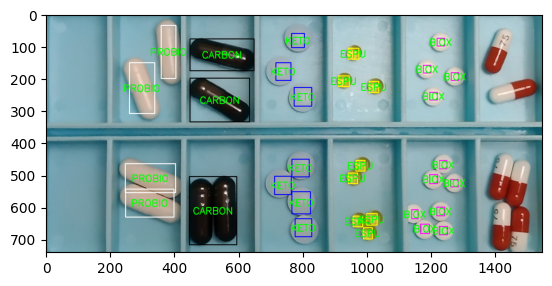

In [21]:
calib = cv2.cvtColor(cv2.imread('images/calib.png'), cv2.COLOR_BGR2RGB)
calib = crop_box(calib, angel=-10)
found = detect_objects(cv2.cvtColor(calib, cv2.COLOR_RGB2BGR))
display_objects(calib, found)

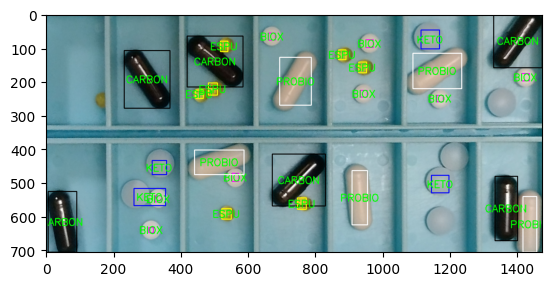

In [22]:
test = cv2.cvtColor(cv2.imread('images/test.png'), cv2.COLOR_BGR2RGB)
test = crop_box(test, angel=21)

found = detect_objects(cv2.cvtColor(test, cv2.COLOR_RGB2BGR))
display_objects(test, found)

### Test

Przetestuj swój algorytm na obrazie testowym `test.png` (lub `test_line.png`, jeśli podejmujesz się detekcji klasy LINE).
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

---

### Zadanie dodatkowe - dla chętnych

Cel: zliczenie wystąpień leków w poszczególnych komórkach organizera.

Wykorzystaj transformację Hougha do wykrycia linii oddzielających komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
szczegóły układu tej struktury są dowolne.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.